In [180]:
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

import catboost
from catboost import CatBoostClassifier
import shap

In [181]:
mirabito = pd.read_csv('G:/gdev/Documents/research/Data/mirabito.txt', dtype={40: 'object', 54: 'object'})

In [182]:
loyalty_cols = ['OIdPos_loyalty_card_dim1', 'loyalty_program1', 'OIdPos_loyalty_card_dim2', 'loyalty_program2', 'OIdPos_loyalty_card_dim3', 
                'loyalty_program3']

#not sure what loyalty_program2 is, but loyalty_program1 seems like it corresponds to rewards, debit, credit

for col in loyalty_cols:
    print(mirabito[col].value_counts().head(5))
    print()
for col in mirabito.columns:
    print(col, mirabito[col].dtype)

298080.0    4417
302825.0    3966
284250.0    3774
367653.0    3617
47008.0     3479
Name: OIdPos_loyalty_card_dim1, dtype: int64

Loyalty 1    992099
Loyalty 3     29348
Loyalty 2      6861
Name: loyalty_program1, dtype: int64

-1.0         1026456
 402704.0        105
 370641.0         70
 294484.0         58
 423057.0         51
Name: OIdPos_loyalty_card_dim2, dtype: int64

Loyalty 1    1628
Loyalty 3     194
Loyalty 2      30
Name: loyalty_program2, dtype: int64

-1.0    1028308
Name: OIdPos_loyalty_card_dim3, dtype: int64

Series([], Name: loyalty_program3, dtype: int64)

FOIdEmployee_dim_key int64
FOIdStore_dim_key int64
FOIdDate_dim_key_file int64
FOIdDate_dim_key_business int64
FOIdDate_dim_key_transaction int64
FOIdTime_of_day_dim_key int64
FOIdItem_dim_key int64
FOIdGtin_plu_dim_key int64
FOIdFuel_selling_product_dim int64
FOIdFuel_position_dim_key int64
FOIdRevenue_dim int64
FOIdPos_event_type_dim int64
FOIdPos_event_line_type_dim int64
FOIdPos_sales_restriction_dim int64
FO

In [183]:
biz_cols = ['OIdPos_loyalty_card_dim1', 'trans_id', 'FOIdCategory_dim', 'qty_sold', 'actual_unit_price', 'selling_units', 'regular_price_per_gallon', 'gallons_sold', 'discounted_gallons_sold', 'non_fuel_loyalty_discount', 'total_discount', 'total_fuel_dollars', 'total_transaction_dollars', 'payment_amount', 'trans_time']
obj_features = [col for col in mirabito.columns if mirabito[col].dtype == 'object']
obj_features

['trans_time',
 'trans_end_time',
 'refund',
 'loyalty_program1',
 'loyalty_program2',
 'payment_type']

In [184]:
mirabito[(mirabito['OIdPos_loyalty_card_dim1'] == 284250.0)][biz_cols].head(10)

,OIdPos_loyalty_card_dim1,trans_id,FOIdCategory_dim,qty_sold,actual_unit_price,selling_units,regular_price_per_gallon,gallons_sold,discounted_gallons_sold,non_fuel_loyalty_discount,total_discount,total_fuel_dollars,total_transaction_dollars,payment_amount,trans_time
2248679,284250.0,337122,5046,8.0,1.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,13,12:52:59.0000000
2248680,284250.0,337122,5046,8.0,1.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,0,12:52:59.0000000
2248681,284250.0,337122,4670,8.0,0.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,13,12:52:59.0000000
2248720,284250.0,337122,4670,8.0,0.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,0,12:52:59.0000000
2248721,284250.0,337122,4474,1.0,1.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,13,12:52:59.0000000
2248722,284250.0,337122,4474,1.0,1.0,1,0.0,0.0,0.0,0.0,-1.12,0.0,12.0,0,12:52:59.0000000
2254255,284250.0,341885,5046,10.0,1.0,1,0.0,0.0,0.0,0.0,-1.40,0.0,13.0,14,12:54:57.0000000
2254256,284250.0,341885,4670,10.0,0.0,1,0.0,0.0,0.0,0.0,-1.40,0.0,13.0,14,12:54:57.0000000
2261096,284250.0,348483,4502,1.0,3.0,1,0.0,0.0,0.0,0.0,0.00,0.0,3.0,3,15:59:49.0000000
2261097,284250.0,348483,4502,1.0,3.0,1,0.0,0.0,0.0,0.0,0.00,0.0,3.0,0,15:59:49.0000000


In [185]:
#top selling fuel products
mirabito['FOIdFuel_selling_product_dim'].value_counts().head(5)
#can we assume these are also the same products that members get the most points from?
#not necessarily, depends on factors such as pricing and points rewarded

-1      5788368
 652      89751
 502      54566
 138      48948
 224      40735
Name: FOIdFuel_selling_product_dim, dtype: int64

In [186]:
mirabito[mirabito['FOIdFuel_selling_product_dim'] == 652][biz_cols].head(20)
#total_fuel_dollars comes with gallons_sold
#duplicate transactions represent giving back change
#can assume payment_amount values for NA total transaction?

,OIdPos_loyalty_card_dim1,trans_id,FOIdCategory_dim,qty_sold,actual_unit_price,selling_units,regular_price_per_gallon,gallons_sold,discounted_gallons_sold,non_fuel_loyalty_discount,total_discount,total_fuel_dollars,total_transaction_dollars,payment_amount,trans_time
1722583,NaN,386923,-1,9.430,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,08:55:39.0000000
1722584,NaN,386926,-1,8.360,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,11:05:43.0000000
1722657,NaN,386958,-1,4.200,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,08:26:12.0000000
1722658,306386.0,386961,-1,15.654,2.0,1,3.0,15.654,1.0,0.0,-6.26,35.0,35.0,40,08:46:14.0000000
1722659,306386.0,386961,-1,15.654,2.0,1,3.0,15.654,1.0,0.0,-6.26,35.0,35.0,-5,08:46:14.0000000
1722666,NaN,386984,-1,14.712,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,09:55:51.0000000
1722667,NaN,386987,-1,11.072,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,10:17:54.0000000
1722668,NaN,386993,-1,11.835,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,10:29:29.0000000
1722669,268439.0,387003,-1,8.355,2.0,1,3.0,8.355,1.0,0.0,-5.85,16.0,16.0,20,10:51:40.0000000
1722711,268439.0,387003,-1,8.355,2.0,1,3.0,8.355,1.0,0.0,-5.85,16.0,16.0,-4,10:51:40.0000000


In [187]:
loyalty_id_counts = mirabito['OIdPos_loyalty_card_dim1'].value_counts()
print(loyalty_id_counts.describe())
#print(sum(loyalty_id_counts.index >= 10))
#sns.distplot(loyalty_id_counts)
print(sum(mirabito['OIdPos_loyalty_card_dim1'].isna())) #non loyal transactions

count    26820.000000
mean        38.341089
std        151.912000
min          1.000000
25%          2.000000
50%          6.000000
75%         15.000000
max       4417.000000
Name: OIdPos_loyalty_card_dim1, dtype: float64
5281971


In [188]:
mirabito['Is_Loyal'] = ~mirabito['OIdPos_loyalty_card_dim1'].isna()
#or loyalty_id_counts[loyalty_id_counts >= 1
mirabito['Is_Loyal'] = mirabito['Is_Loyal'].astype(int)

In [189]:
mirabito['FOIdDate_dim_key_transaction'] = pd.to_datetime(mirabito['FOIdDate_dim_key_transaction'], format='%Y%m%d')
#use trans_time field instead if we want continuous instead of discrete measures of time like days

In [190]:
mirabito_loyal = mirabito[mirabito['Is_Loyal'] == 1] \
.groupby('OIdPos_loyalty_card_dim1').apply(pd.DataFrame.sort_values, 'FOIdDate_dim_key_transaction')
#mirabito[mirabito['OIdPos_loyalty_card_dim1'].isin(loyalty_id_counts[loyalty_id_counts >= 1].index)] \

'''
Ideas: 
-from loyalty members, compare (average, date of first purchase - date of last) / #) purchase freq to 
(average interval between next transaction)- actually mathematically they are the same
-check if number of transactions is correlated with how much discounted- a proxy towards seeing how many reward points are associated with each account
-incorporate intraday spending info by plotting total spent that day (or week since there may be intermittent demand) 
against day and constructing a time series
-group a series of transactions into distinct visits (what counts as a visit? unique transaction time, within 15 min of each other?)
-find customers with low variance in payment amounts to indicate consistency

Business questions:
-what are buying patterns of loyal members? these require subqueries/data on most popular products, frequency of transaction
-are they more likely to be buying fuel products?
-are the most popular fuel products also the ones that reward the most points?
-what are points being spent on? it is more fuel or non-fuel?

Observations:
-the distribution of time intervals led us to group into mean intervals of transaction data
-what does FOIdCategory_dim = -1 mean? along with qty_sold = NaN?
-transaction types could be refund, unsuccessful, no barcode/category, duplicates

Concerns:
-without being able to account for 'errors' in transaction log, results may be inaccurate, best to ask the source
'''

"\nIdeas: \n-from loyalty members, compare (average, date of first purchase - date of last) / #) purchase freq to \n(average interval between next transaction)- actually mathematically they are the same\n-check if number of transactions is correlated with how much discounted- a proxy towards seeing how many reward points are associated with each account\n-incorporate intraday spending info by plotting total spent that day (or week since there may be intermittent demand) \nagainst day and constructing a time series\n-group a series of transactions into distinct visits (what counts as a visit? unique transaction time, within 15 min of each other?)\n-find customers with low variance in payment amounts to indicate consistency\n\nBusiness questions:\n-what are buying patterns of loyal members? these require subqueries/data on most popular products, frequency of transaction\n-are they more likely to be buying fuel products?\n-are the most popular fuel products also the ones that reward the m

In [191]:
bins_dt = pd.date_range(start='2017-12-31', end='2018-12-31', freq='W')
mirabito['trans_week'] = pd.cut(mirabito['FOIdDate_dim_key_transaction'], bins=bins_dt)
mirabito[mirabito['Is_Loyal'] == 1].groupby('OIdPos_loyalty_card_dim1')['trans_week'].nunique().loc[lambda x: x == 52]

OIdPos_loyalty_card_dim1
21423.0     52
31707.0     52
32107.0     52
33071.0     52
33101.0     52
36262.0     52
45887.0     52
47805.0     52
54677.0     52
63692.0     52
114284.0    52
118593.0    52
142397.0    52
153546.0    52
163875.0    52
179051.0    52
212770.0    52
216441.0    52
217434.0    52
237215.0    52
237335.0    52
241674.0    52
282141.0    52
282548.0    52
282554.0    52
282609.0    52
283125.0    52
283135.0    52
283607.0    52
283955.0    52
            ..
287346.0    52
290838.0    52
292815.0    52
298084.0    52
298684.0    52
298724.0    52
299425.0    52
301396.0    52
301402.0    52
301403.0    52
316178.0    52
325009.0    52
325390.0    52
327723.0    52
338068.0    52
340012.0    52
341896.0    52
342278.0    52
346631.0    52
367653.0    52
367961.0    52
383027.0    52
394170.0    52
397571.0    52
401873.0    52
402720.0    52
416063.0    52
419434.0    52
434249.0    52
435362.0    52
Name: trans_week, Length: 63, dtype: int64

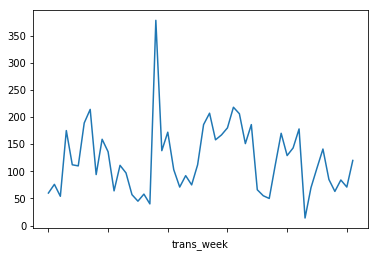

In [192]:
mirabito[mirabito['OIdPos_loyalty_card_dim1'] == 283607.0].groupby('trans_week').payment_amount.agg('sum').plot()

In [193]:
'''
suppose we wanted to upsample the transactions to be weekly time series data, how many rows would that be?
print(len(mirabito_loyal['OIdPos_loyalty_card_dim1'].unique()))
mirabito[mirabito['Is_Loyal'] == 1].groupby(['OIdPos_loyalty_card_dim1', pd.Grouper(key='FOIdDate_dim_key_transaction', freq='W')]).payment_amount.agg('sum')
should be pretty much the same, but much slower and has NAs
mirabito[mirabito['Is_Loyal'] == 1].groupby('OIdPos_loyalty_card_dim1').apply(lambda x: x.groupby(['FOIdDate_dim_key_transaction']).payment_amount.agg('sum').reset_index().set_index('FOIdDate_dim_key_transaction').resample('W').asfreq())
'''

"\nsuppose we wanted to upsample the transactions to be weekly time series data, how many rows would that be?\nprint(len(mirabito_loyal['OIdPos_loyalty_card_dim1'].unique()))\nmirabito[mirabito['Is_Loyal'] == 1].groupby(['OIdPos_loyalty_card_dim1', pd.Grouper(key='FOIdDate_dim_key_transaction', freq='W')]).payment_amount.agg('sum')\nshould be pretty much the same, but much slower and has NAs\nmirabito[mirabito['Is_Loyal'] == 1].groupby('OIdPos_loyalty_card_dim1').apply(lambda x: x.groupby(['FOIdDate_dim_key_transaction']).payment_amount.agg('sum').reset_index().set_index('FOIdDate_dim_key_transaction').resample('W').asfreq())\n"

In [195]:
mirabito['trans_time'] = pd.to_datetime(mirabito['trans_time'], format='%H:%M:%S.%f') #.dt.time

In [217]:
mirabito_trans_std = mirabito[mirabito['Is_Loyal'] == 1].groupby(['OIdPos_loyalty_card_dim1', 'FOIdDate_dim_key_transaction', 'trans_time']).payment_amount.agg('sum').groupby(level='OIdPos_loyalty_card_dim1').std()
mirabito_trans_std.dropna().sort_values()

OIdPos_loyalty_card_dim1
525205.0       0.000000
395081.0       0.000000
169075.0       0.000000
455163.0       0.000000
450396.0       0.000000
393293.0       0.000000
560767.0       0.000000
501733.0       0.000000
561987.0       0.000000
565319.0       0.000000
432651.0       0.000000
173133.0       0.000000
468903.0       0.000000
391711.0       0.000000
433174.0       0.000000
176501.0       0.000000
556239.0       0.000000
431650.0       0.000000
456178.0       0.000000
497197.0       0.000000
561984.0       0.000000
557017.0       0.000000
400838.0       0.000000
400043.0       0.000000
534263.0       0.000000
477516.0       0.000000
450439.0       0.000000
469563.0       0.000000
395973.0       0.000000
398270.0       0.000000
               ...     
473758.0     328.097546
431919.0     329.511760
487400.0     332.340187
223081.0     333.047294
395976.0     337.516744
481348.0     344.991146
514883.0     346.482323
492935.0     362.664216
525549.0     365.157370
551653.0     36

In [205]:
'''
trans_date_group = mirabito[mirabito['Is_Loyal'] == 1].groupby(['OIdPos_loyalty_card_dim1', 'FOIdDate_dim_key_transaction'])

trans_date_group.apply(
    pd.cut(trans_date_group['trans_time'], 
           np.arange(np.min(trans_date_group['trans_time']), np.min(trans_date_group['trans_time'])+pd.Timedelta(minutes=15))
          )).sum()
'''

"\ntrans_date_group = mirabito[mirabito['Is_Loyal'] == 1].groupby(['OIdPos_loyalty_card_dim1', 'FOIdDate_dim_key_transaction'])\n\ntrans_date_group.apply(\n    pd.cut(trans_date_group['trans_time'], \n           np.arange(np.min(trans_date_group['trans_time']), np.min(trans_date_group['trans_time'])+pd.Timedelta(minutes=15))\n          )).sum()\n"

In [12]:
#how much is number of transactions is correlated with total discounted?
#there can be customers that make more than one transaction but never got the card- only members can have discounts
mirabito[mirabito['Is_Loyal'] == 1].groupby('OIdPos_loyalty_card_dim1').agg({'total_discount': 'sum', 'payment_amount': ['size', 'sum']}).corr()
#high correlation as expected (.75)
#how about total spent and how much discounted?
#surprisingly lower than corr b/w # of transactions

total_discount payment_amount          
                               sum           size       sum
total_discount sum        1.000000      -0.754667 -0.694110
payment_amount size      -0.754667       1.000000  0.787024
               sum       -0.694110       0.787024  1.000000

In [13]:
mirabito_loyal[biz_cols].head(25)

OIdPos_loyalty_card_dim1  trans_id  \
OIdPos_loyalty_card_dim1                                               
289.0                    682753                      289.0   1158590   
                         1634220                     289.0   1158595   
                         1639874                     289.0   1158590   
309.0                    3862909                     309.0    789829   
310.0                    1741868                     310.0    394410   
                         1741869                     310.0    394410   
                         1741870                     310.0    394410   
                         1741871                     310.0    394410   
                         4721329                     310.0    419107   
                         4632196                     310.0    419160   
                         4632194                     310.0    419160   
                         4632195                     310.0    419160   
                         4599493                     310.0    418727   
                         4665988                     310.0    419415   
                         4337843                     310.0    482318   
                         4733529                     310.0    489344   
                         4733530                     310.0    489344   
                         4842586                     310.0    496557   
                         4781668                     310.0    496559   
                         2111750                     310.0    497187   
                         4856991                     310.0    564741   
1907.0                   4785191                    1907.0    521903   
1949.0                   62746                      1949.0    859505   
                         62747                      1949.0    859505   
                         62748                      1949.0    859505   

                                  FOIdCategory_dim  qty_sold  \
OIdPos_loyalty_card_dim1                                       
289.0                    682753               1509     1.000   
                         1634220                -1    24.856   
                         1639874              1509     1.000   
309.0                    3862909               323     2.000   
310.0                    1741868                -1    12.769   
                         1741869                -1    12.769   
                         1741870              5120     1.000   
                         1741871              5120     1.000   
                         4721329                -1    12.324   
                         4632196                -1       NaN   
                         4632194              5045     2.000   
                         4632195              4669     2.000   
                         4599493                -1    26.811   
                         4665988                -1     6.923   
                         4337843                -1    15.517   
                         4733529                -1       NaN   
                         4733530                -1       NaN   
                         4842586                -1       NaN   
                         4781668                -1       NaN   
                         2111750              4445     1.000   
                         4856991                -1       NaN   
1907.0                   4785191              4473     2.000   
1949.0                   62746                  -1       NaN   
                         62747                1441     2.000   
                         62748                3974     2.000   

                                  actual_unit_price  selling_units  \
OIdPos_loyalty_card_dim1                                             
289.0                    682753                 9.0              1   
                         1634220                3.0              1   
                         1639874                9.0              1   
309.0     

In [14]:
trans_interval = mirabito_loyal['FOIdDate_dim_key_transaction'].groupby('OIdPos_loyalty_card_dim1').diff(periods=1)
trans_interval_int = trans_interval[~trans_interval.isna()].dt.days.astype(int)

C:\Users\gdev\AppData\Local\conda\conda\envs\boosting\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


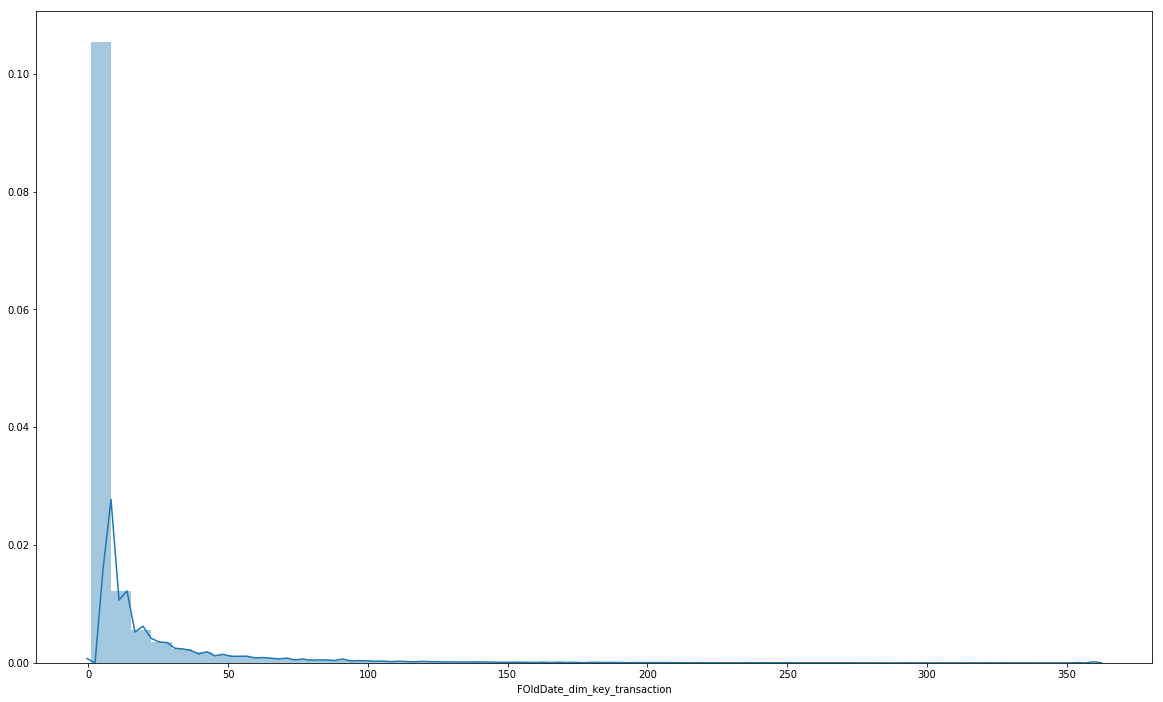

In [59]:
#graph the distribution of intervals between transactions in days
plt.figure(figsize=(20, 12))
sns.distplot(trans_interval_int[trans_interval_int != 0])

(array([67288,     0,     0, ...,     0,     0,     1], dtype=int64), array([  1.        ,   1.23575639,   1.47151277, ..., 360.52848723,
       360.76424361, 361.        ]))
209077


(array([1.36511078e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.02875814e-05]),
 array([  1.        ,   1.23575639,   1.47151277, ..., 360.52848723,
        360.76424361, 361.        ]),
 <a list of 1527 Patch objects>)

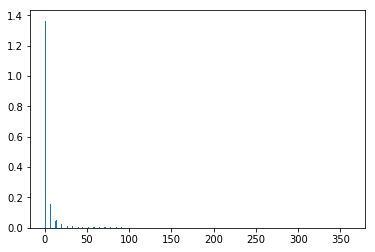

In [16]:
#keep in mind the first bin just contains the set of all transactions that had an average of 1-1.23 days after
#to form a frequent customers group we'll need parameters on 2 dimensions: overall # of transactions and time intervals
#plt.hist(np.histogram(trans_interval_int[trans_interval_int != 0], 'fd')[0], bins=np.histogram(trans_interval_int[trans_interval_int != 0], 'fd')[1])
print(np.histogram(trans_interval_int[trans_interval_int != 0], 'fd'))
print(len(trans_interval_int[trans_interval_int != 0]))
plt.hist(trans_interval_int[trans_interval_int != 0], bins='fd', density=True, rwidth=1)
#the value on the y-axis is the probability density, the probability per unit on the x-axis
#since we don't have an area under the curve it doesn't have to integrate to 1, however it is still valid for relative comparison

In [17]:
#get transactions that are less than or equal to a week apart from the last, doesn't mean customers that shop weekly- misleading
#any customers that identify with these transactions are included, doesn't necessarily indicate frequency
#on the other hand simply counting regular intervals as a measure of freq suffers from the problem of being non contiguous
cust_weekly = trans_interval_int[(trans_interval_int > 0) & (trans_interval_int <= 7)].groupby('OIdPos_loyalty_card_dim1').agg('count')
print(cust_weekly.describe())
#mirabito_loyal.where(cust_weekly >= 17)
#mirabito_loyal.index.get_level_values(0)
#boolean masking not working as intended with multiindex so reconstruct

count    7906.000000
mean       19.468758
std        39.617138
min         1.000000
25%         1.000000
50%         4.000000
75%        17.000000
max       347.000000
Name: FOIdDate_dim_key_transaction, dtype: float64


In [18]:
mirabito_freq = mirabito[mirabito['Is_Loyal'] == 1][mirabito['OIdPos_loyalty_card_dim1'].isin(cust_weekly[cust_weekly >= 17].index)]
mirabito_freq.groupby('OIdPos_loyalty_card_dim1').apply(pd.DataFrame.sort_values, 'FOIdDate_dim_key_transaction')

C:\Users\gdev\AppData\Local\conda\conda\envs\boosting\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


FOIdEmployee_dim_key  FOIdStore_dim_key  \
OIdPos_loyalty_card_dim1                                                    
21399.0                  2394354                  4840                 48   
                         2394355                  4840                 48   
                         2394356                  4840                 48   
                         2394357                  4840                 48   
                         2406066                  4840                 48   
                         2407541                  4840                 48   
                         2407542                  4840                 48   
                         2428444                  3927                 48   
                         2428445                  3927                 48   
                         2428446                  3927                 48   
                         2436419                  3927                 48   
                         2438511                  4840                 48   
                         2438510                  4840                 48   
                         2437077                  4840                 48   
                         2436417                  3927                 48   
                         2436418                  3927                 48   
                         2441373                  4840                 48   
                         2441374                  4840                 48   
                         2441375                  4840                 48   
                         2441376                  4840                 48   
                         2444127                  6128                 48   
                         2444126                  6128                 48   
                         2444129                  6128                 48   
                         2444128                  6128                 48   
                         2447096                  4840                 48   
                         2447094                  4840                 48   
                         2447095                  4840                 48   
                         951390                   4840                 48   
                         2449775                  4840                 48   
                         951392                   4840                 48   
...                                                ...                ...   
558562.0                 5443976                  6771                 94   
                         5443972                  6771                 94   
                         5444020                  6771                 94   
                         5443978                  6771                 94   
                         2578476                  6771                 94   
                         2578477                  6771                 94   
                         2578466                  6771                 94   
                         2578467                  6771                 94   
                         2578468                  6771                 94   
                         2578469                  6771                 94   
                         2578473                  6771                 94   
                         2578471                  6771                 94   
                         2578472                  6771                 94   
                         2578475                  6771                 94   
                         2578474                  6771                 94   
                         2578470                  6771                 94   
                         5343743                  6855                 94   
                         5343742                  6855                 94   
                         5343741                  6855                 94   
                         53437

limit_output extension: Maximum message size of 30000 exceeded with 60302 characters

-1      5788368
 652      89751
 502      54566
 138      48948
 224      40735
Name: FOIdFuel_selling_product_dim, dtype: int64
-1      707437
 502      4029
 59       3000
 138      2508
 618      2087
Name: FOIdFuel_selling_product_dim, dtype: int64
0.9172919295644456
0.9644636763585153


([<matplotlib.patches.Wedge at 0x201ecf06a20>,
 [Text(0.5097977736765228, 0.9747339277743753, '502'),
  Text(-1.087154905380897, 0.16761328022043132, '59'),
  Text(-0.25626958264566535, -1.0697316958053626, '138'),
  Text(0.929607212843135, -0.5880734901608969, '618')],
 [Text(0.27807151291446697, 0.5316730515132956, '34.7%'),
  Text(-0.5929935847532165, 0.0914254255747807, '25.8%'),
  Text(-0.13978340871581746, -0.5834900158938341, '21.6%'),
  Text(0.5070584797326191, -0.3207673582695801, '18.0%')])

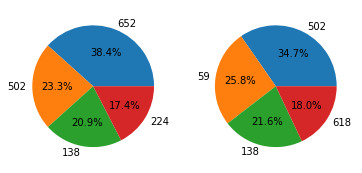

In [19]:
print(mirabito['FOIdFuel_selling_product_dim'].value_counts().head(5))
print(mirabito_freq['FOIdFuel_selling_product_dim'].value_counts().head(5))
print(mirabito['FOIdFuel_selling_product_dim'].value_counts().values[0] / mirabito['FOIdFuel_selling_product_dim'].count())
print(mirabito_freq['FOIdFuel_selling_product_dim'].value_counts().values[0] / mirabito_freq['FOIdFuel_selling_product_dim'].count())
fig3, (ax31, ax32) = plt.subplots(1, 2)
ax31.pie(mirabito['FOIdFuel_selling_product_dim'].value_counts().head(5)[1:], labels=mirabito['FOIdFuel_selling_product_dim'].value_counts().head(5).index[1:], autopct='%1.1f%%')
ax32.pie(mirabito_freq['FOIdFuel_selling_product_dim'].value_counts().head(5)[1:], labels=mirabito_freq['FOIdFuel_selling_product_dim'].value_counts().head(5)[1:].index, autopct='%1.1f%%')

#findings: the freq customers buy proportionally more things besides fuel on average
#different breakdowns on top 5 fuel products

In [20]:
print(len(trans_interval[~trans_interval.isna()][298080.0]) / np.sum(trans_interval[~trans_interval.isna()][298080.0].dt.days.astype(int)))
#mean number of transactions in a day for some customer
print(np.mean(trans_interval_int[trans_interval_int != 0 ][298080.0]))
#average days before next transaction 
#can model using poisson process
#or estimate # of occurences in a given time frame using expectead value of geometric

trans_interval[282585.0]
#check to see if this makes sense for a random customer
#maybe it'll be a good idea to bin the customers into groups- frequent, infrequent, and those who go multiple times a day

12.165289256198347
1.3104693140794224


5002414      NaT
4973623   1 days
Name: FOIdDate_dim_key_transaction, dtype: timedelta64[ns]

In [21]:
#now get the mean interval for every card id
trans_interval_mean = trans_interval_int[trans_interval_int != 0].groupby('OIdPos_loyalty_card_dim1').agg({'mean_interval': 'mean'}).reset_index().sort_values(by='mean_interval', ascending=False)
#groupby again after diffing?
#dict agg being deprecated see issue #18366

#those who have points from buying gallons have very high (ranking) correlation with those who have high # of transactions
#we can actually calculate how many points accrued from given data, having "reward rate" and total spent
#https://www.mirabito.com/rewards-plus-and-payment-cards/#rewards-plus-faq
loyalty_gallons = mirabito[mirabito['Is_Loyal'] == 1].groupby('OIdPos_loyalty_card_dim1').gallons_sold.sum().reset_index().sort_values(by='gallons_sold', ascending=False)
#difference b/w agg and sum?
print(scp.stats.spearmanr(loyalty_gallons['gallons_sold'], mirabito_loyal['OIdPos_loyalty_card_dim1'].value_counts().values))

gallons_interval = pd.merge(trans_interval_mean, loyalty_gallons)
print(scp.stats.pearsonr(gallons_interval['mean_interval'], gallons_interval['gallons_sold']))
#no linear relationship

C:\Users\gdev\AppData\Local\conda\conda\envs\boosting\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


SpearmanrResult(correlation=0.9165655762588302, pvalue=0.0)
(-0.06342091936645877, 1.2379771127178131e-13)


(1028308,) (26820, 2)


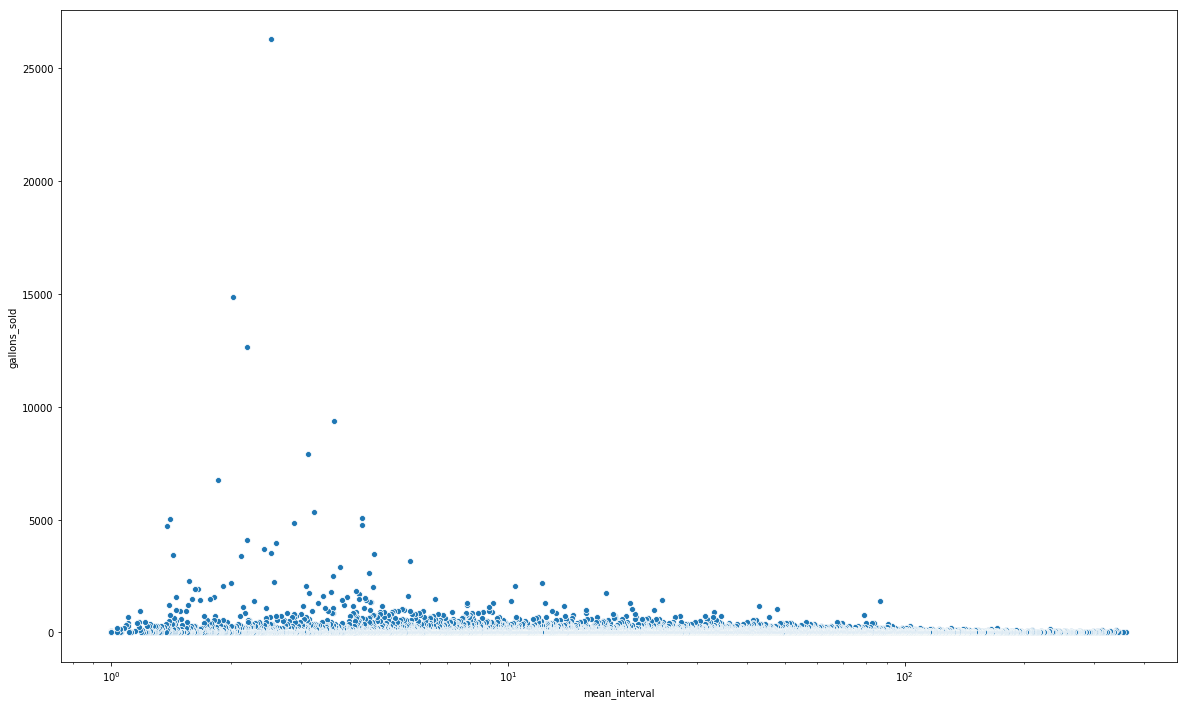

In [58]:
#next plot average days before next transaction against points
print(trans_interval.shape, loyalty_gallons.shape) #after removing na values and rows with only zero diff
plt.figure(figsize=(20, 12))
sns.scatterplot(gallons_interval['mean_interval'], gallons_interval['gallons_sold'])
plt.xscale('log')
#although there is no linear relationship, we can see that all high value customers have small means